## ***Modelo para reconhecer o alfabeto em datilologia ;)***

<br>

#### letras possíveis de reconhecimento : a b c d e f g i l m n o p q r s t u v w y
#### letras excluidas por possuirem movimento: h j x z ç

<br>

#### Por questões computacionais, optamos por rodar o código de treinamento via google colab, assim como instânciar nosso dataset no google drive. Apartir do treinamento usamos o normalizador e modelo treinado para realizar a inferência visto que há divergencias quando usando camera no google colab. Utilizamos então, o código de inferência nas IDE's VSCODE, Anaconda e Pycharm, todos com sucesso.
<br>

#### **dataset:** https://drive.google.com/drive/folders/1yj5MFGbC0AeQesvu0vlkyguT4C7Gx8Fw?usp=sharing

<br>

#### **Relatório:** https://www.canva.com/design/DAFko3CLyy0/AfB6k-wcavVht8tiFnWzYg/edit?utm_content=DAFko3CLyy0&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton

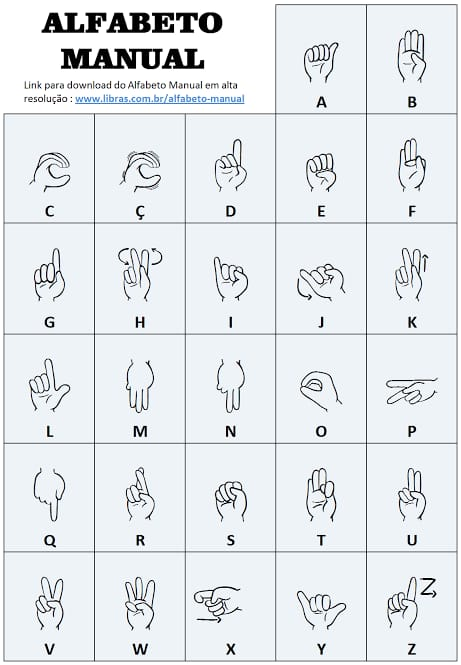

# **Parte 0 - Configuração de ambiente**

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 44.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import mediapipe as mp
import csv
from google.colab.patches import cv2_imshow
import pandas as pd
from imblearn.over_sampling import SMOTE
from pickle import dump, load
from sklearn import preprocessing as pp
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Parte 1 -  Gerar o dataset e extrair coordenadas**

`````
OBS: Script usado para gerar o banco de imagens
`````


In [ ]:
video = cv2.VideoCapture(0)
l = input("letra a ser gravada: ")[0].upper()
input("Pronto? pressione qualquer tecla para iniciar...")

i = 0
while i < 1800:
    check, img = video.read()
    if check:
        cv2.imwrite(l+str(i)+"Nome"+".jpg", img)
        cv2.waitKey(1)
        print(i, "de", 1800, end="\r")
        i += 1
    else:
        print("Falha ao ler imagem")

````
A. Ler o dataset com as imagens de cada letra que geramos
````

In [ ]:
dataset_path = "/content/drive/MyDrive/photos"
script_path = os.path.dirname('/content/drive/MyDrive/')
csv_file = os.path.join(script_path, 'coordenates.csv')

```
B. Usar a lib do mediapipe para vetorizar as imagens e extrair as coordenadas das mãos.
As coordenadas são serializadas em um csv com 43 colunas:
*   IMAGE que pega a letra que está sendo serializada pelo nome da imagem;
*   21 para coordenadas X de cada vetor;
*   21 para as coordenadas Y de cada vetor.
```

In [ ]:
mpHands = mp.solutions.hands
hands = mpHands.Hands()
mpDraw = mp.solutions.drawing_utils

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    header = ["IMAGE"]
    for i in range(1, 22):
        header.extend([f"VETOR{i}X", f"VETOR{i}Y"])
    writer.writerow(header)

    for root, dirs, files in os.walk(dataset_path):
        for filename in files:
            if filename.endswith(".jpg"):
                image_path = os.path.join(root, filename)
                img = cv2.imread(image_path)
                imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                results = hands.process(imgRGB)

                landmarks = []

                if results.multi_hand_landmarks:
                    for handlms in results.multi_hand_landmarks:
                        landmarks = [filename[0]]
                        for id, lm in enumerate(handlms.landmark):
                            h, w, c = img.shape
                            cx, cy = int(lm.x * w), int(lm.y * h)
                            landmarks.extend([cx, cy])
                            cv2.circle(img, (cx, cy), 15, (255, 0, 255), cv2.FILLED)

                        mpDraw.draw_landmarks(img, handlms, mpHands.HAND_CONNECTIONS)

                writer.writerow(landmarks)

                #cv2_imshow(img)
                cv2.waitKey(0)

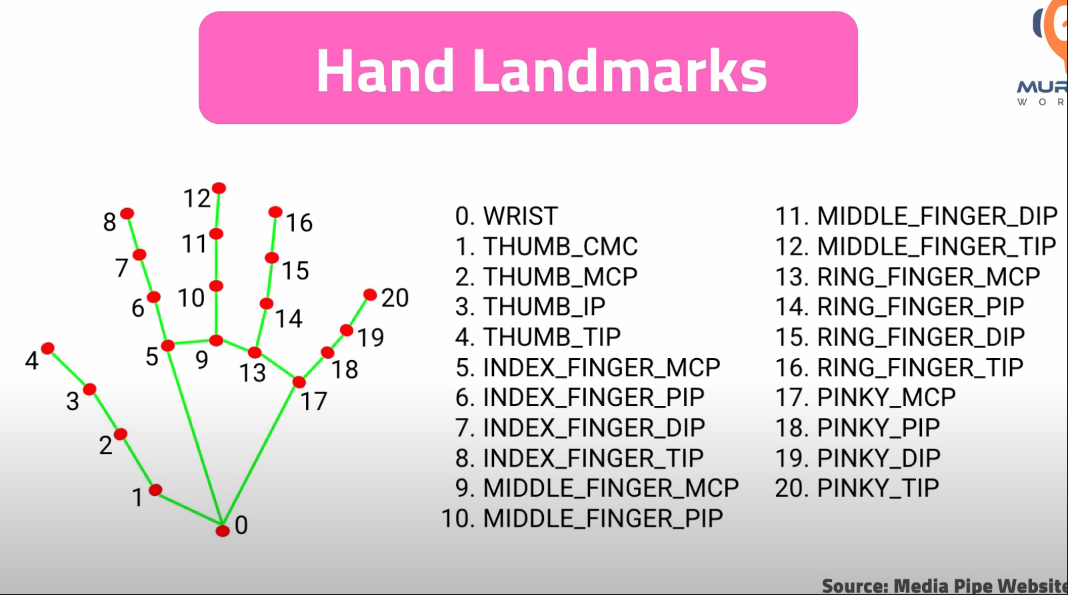

````
C. Ler o csv de coordenadas e criar um DataFrame com esses dados
````

In [ ]:
coordinates_data = pd.read_csv('/content/drive/MyDrive/coordenates.csv')

print(coordinates_data)
print(f"Dataset length:{len(coordinates_data)}")

coordinates_columns = coordinates_data.columns

# **Parte 2 - Preprocessing das coordenadas**

````
A. Normalizar os dados desbalanceados
````

In [ ]:
# Criando os atributos das coordenadas, ou seja, vetor[x, y]
data_attributes = coordinates_data.drop(columns=['IMAGE'])
print(f"Data attributes' columns: {data_attributes.columns} \n")
print(f"Data attributes: {data_attributes.value_counts()} \n")

# Criando as classes das coordenadas, ou seja, as letras
data_classes = coordinates_data['IMAGE']
print(f"Data classes: {data_classes.value_counts()} \n")

Data attributes' columns: Index(['VETOR1X', 'VETOR1Y', 'VETOR2X', 'VETOR2Y', 'VETOR3X', 'VETOR3Y',
       'VETOR4X', 'VETOR4Y', 'VETOR5X', 'VETOR5Y', 'VETOR6X', 'VETOR6Y',
       'VETOR7X', 'VETOR7Y', 'VETOR8X', 'VETOR8Y', 'VETOR9X', 'VETOR9Y',
       'VETOR10X', 'VETOR10Y', 'VETOR11X', 'VETOR11Y', 'VETOR12X', 'VETOR12Y',
       'VETOR13X', 'VETOR13Y', 'VETOR14X', 'VETOR14Y', 'VETOR15X', 'VETOR15Y',
       'VETOR16X', 'VETOR16Y', 'VETOR17X', 'VETOR17Y', 'VETOR18X', 'VETOR18Y',
       'VETOR19X', 'VETOR19Y', 'VETOR20X', 'VETOR20Y', 'VETOR21X', 'VETOR21Y'],
      dtype='object') 

Data attributes: VETOR1X  VETOR1Y  VETOR2X  VETOR2Y  VETOR3X  VETOR3Y  VETOR4X  VETOR4Y  VETOR5X  VETOR5Y  VETOR6X  VETOR6Y  VETOR7X  VETOR7Y  VETOR8X  VETOR8Y  VETOR9X  VETOR9Y  VETOR10X  VETOR10Y  VETOR11X  VETOR11Y  VETOR12X  VETOR12Y  VETOR13X  VETOR13Y  VETOR14X  VETOR14Y  VETOR15X  VETOR15Y  VETOR16X  VETOR16Y  VETOR17X  VETOR17Y  VETOR18X  VETOR18Y  VETOR19X  VETOR19Y  VETOR20X  VETOR20Y  VETOR21X  VETOR

In [ ]:
normalizer = pp.MinMaxScaler()

model_normalizer = normalizer.fit(data_attributes)

data_attributes_normalized = normalizer.transform(data_attributes)
data_attributes_normalized = pd.DataFrame(data_attributes_normalized, columns = data_attributes.columns)

print(f"Data attributes normalized: {data_attributes_normalized} \n")
print(f"Data attributes normalized length: {len(data_attributes_normalized)}")

Data attributes normalized:         VETOR1X   VETOR1Y   VETOR2X   VETOR2Y   VETOR3X   VETOR3Y   VETOR4X  \
0      0.677966  0.651605  0.740811  0.635153  0.801587  0.568657  0.883865   
1      0.424726  0.570749  0.486334  0.544607  0.544092  0.480597  0.609043   
2      0.616152  0.621879  0.585297  0.584554  0.569665  0.486567  0.556738   
3      0.458624  0.577883  0.513666  0.523302  0.562610  0.456716  0.609929   
4      0.460618  0.586207  0.519321  0.567244  0.582892  0.497015  0.648050   
...         ...       ...       ...       ...       ...       ...       ...   
74088  0.273180  0.594530  0.221489  0.556591  0.227513  0.471642  0.253546   
74089  0.270189  0.588585  0.221489  0.549933  0.226631  0.467164  0.251773   
74090  0.268195  0.590963  0.219604  0.552597  0.223986  0.470149  0.247340   
74091  0.267198  0.589774  0.217719  0.551265  0.223104  0.468657  0.247340   
74092  0.265204  0.586207  0.216777  0.549933  0.222222  0.465672  0.245567   

        VETOR4Y   VETOR

In [ ]:
# Salvando o modelo normalizador na memória para ser usado na inferência
dump(model_normalizer, open('/content/drive/MyDrive/normalizador_datilologia.model', 'wb'))

`````
C. Balancear os dados das coordenadas usando SMOTE (Synthetic Minority Oversampling Technique)
`````

In [ ]:
# Criando uma instância do SMOTE e balancear os dados de maneira proporcional
resampler = SMOTE()
data_attributes_balanced, data_classes_balanced = resampler.fit_resample(data_attributes_normalized, data_classes)

print(f"Data attributes balanced: {data_attributes_balanced.value_counts()} \n")
print(f"Data classes balanced: {data_classes_balanced.value_counts()}")

Data attributes balanced: VETOR1X   VETOR1Y   VETOR2X   VETOR2Y   VETOR3X   VETOR3Y   VETOR4X   VETOR4Y   VETOR5X   VETOR5Y   VETOR6X   VETOR6Y   VETOR7X   VETOR7Y   VETOR8X   VETOR8Y   VETOR9X   VETOR9Y   VETOR10X  VETOR10Y  VETOR11X  VETOR11Y  VETOR12X  VETOR12Y  VETOR13X  VETOR13Y  VETOR14X  VETOR14Y  VETOR15X  VETOR15Y  VETOR16X  VETOR16Y  VETOR17X  VETOR17Y  VETOR18X  VETOR18Y  VETOR19X  VETOR19Y  VETOR20X  VETOR20Y  VETOR21X  VETOR21Y
0.087737  0.470868  0.054665  0.443409  0.067019  0.377612  0.064716  0.404372  0.085213  0.410127  0.060074  0.381872  0.066487  0.390141  0.089381  0.332869  0.115548  0.341346  0.054656  0.382222  0.062745  0.377682  0.098315  0.385735  0.131878  0.401882  0.054721  0.379822  0.067497  0.379747  0.112608  0.389758  0.147645  0.424828  0.100541  0.384389  0.089852  0.373938  0.120553  0.392758  0.146977  0.422343    2
0.283151  0.235434  0.236569  0.130493  0.235450  0.014925  0.232270  0.079235  0.249791  0.126582  0.283734  0.043091  0.292902  0

# **Parte 3 - Treinamento usando hyperparametrização**




`````
A. Criar a Random Forest
`````

In [ ]:
rf = RandomForestClassifier()

# Determinar as faixas de valores para cada hiperparâmetro
n_estimators = [int(x) for x in np.linspace(start=10, stop=300, num=10)]
criterion = ['gini', 'entropy']
min_samples_split = [int(x) for x in np.linspace(start=2, stop=10, num=3)]
max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
max_features = ['auto', 'sqrt', 'log2']

# Criar grade de valores
rf_grid = {
    'n_estimators':n_estimators,
    'criterion': criterion,
    'min_samples_split': min_samples_split,
    'max_depth': max_depth,
    'max_features': max_features
}

In [ ]:
# Cross validation -> segmenta a base e treina cada um individualmente e depois tira a média de todos eles
# Pensar na segmentação -> confiança e erro amostral!

# (Indutor) Construir um objeto a partir da RandomForestClassifier
rf_hyperparameters = RandomizedSearchCV(estimator = rf,
                                        param_distributions = rf_grid,
                                        n_iter = 10,
                                        cv = 10, # trocar para dez
                                        verbose = 1,
                                        random_state = 42,
                                        n_jobs = -1)


In [ ]:
rf_hyperparameters.fit(data_attributes_balanced, data_classes_balanced)

#Imprimir a melhor combinação de hiperparâmetros
pprint(rf_hyperparameters.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 138}


`````
B. Criando a árvore de decisão e treinar
`````

In [ ]:
tree = DecisionTreeClassifier()

# Treinar o modelo
rf = RandomForestClassifier(**rf_hyperparameters.best_params_)
trained_rf = tree.fit(data_attributes_balanced, data_classes_balanced)

pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 138,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


# **Parte 4 - Testar o modelo**

`````
Especificidade: capacidade de obter verdadeiros negativos
Sensibilidade: capacidade de obter verdadeiros positivos
`````


In [ ]:
#Testar o modelo CROSS VALIDATION

scoring=['precision_macro','recall_macro']

scores_cross = cross_validate(trained_rf, data_attributes_balanced,data_classes_balanced,cv=10, scoring = scoring) #Rodar o cross validate da forma nativa
print(f"Cross score keys: {scores_cross.keys()} \n")

print(f"Sensibility matrix: {scores_cross['test_precision_macro']} \n")
print(f"Specificity matrix: {scores_cross['test_recall_macro']} \n")


#Métricas finas: calcular as medias
print('Sensibility: {:2.2f}%'.format(scores_cross['test_recall_macro'].mean()*100))#tp/tp+fn
print('Specificity {:2.2f}%'.format(scores_cross['test_precision_macro'].mean()*100))#tn/tn+fp

predicted_labels = cross_val_predict(trained_rf, data_attributes_balanced, data_classes_balanced, cv=10)
accuracy = accuracy_score(data_classes_balanced, predicted_labels)

print('Accuracy: {:.2f}%'.format(accuracy * 100))

Cross score keys: dict_keys(['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']) 

Sensibility matrix: [0.74222512 0.71637893 0.83496386 0.86733526 0.76795592 0.8433276
 0.89392157 0.91829256 0.8954692  0.93484109] 

Specificity matrix: [0.72416169 0.71645275 0.82782188 0.856604   0.75909776 0.84076939
 0.8886008  0.90998019 0.88651783 0.93177923] 

Sensibility: 83.42%
Specificity 84.15%
Accuracy: 83.46%


In [ ]:
#Printando os resultados do predict e comparando com as classes reais
# list(map(lambda true, pred: print(f"True label: {true}, Predicted: {pred}"), data_classes_balanced, predicted_labels))

for true, pred in zip(data_classes_balanced, predicted_labels):
    print(f"True label: {true}, Predicted: {pred}")

In [ ]:
dump(trained_rf,open('/content/drive/MyDrive/tree_cross_model.pkl', 'wb'))

``````
Criando a matriz de contingência
``````

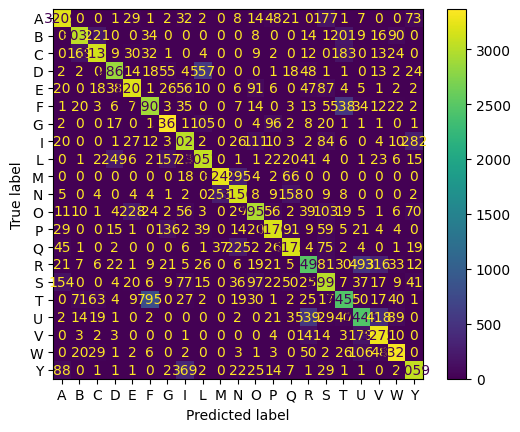

In [ ]:
#Matriz da contigência
cm = confusion_matrix(data_classes_balanced, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trained_rf.classes_)

disp.plot()
plt.show()

# **Parte 5 - Inferência de novas instâncias**

`````
A. Usar o cv para ligar a camêra e pegar as imagens até o usuário apertar uma tecla para parar
`````

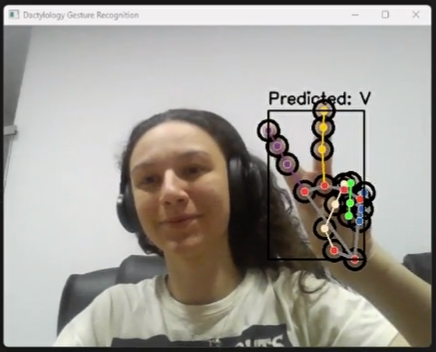

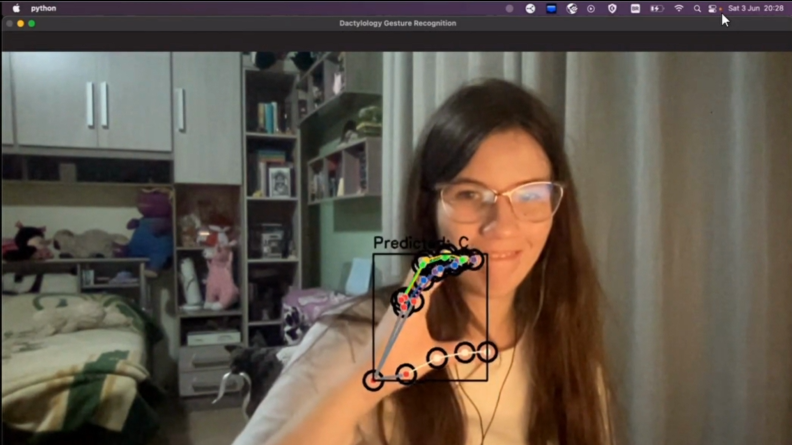

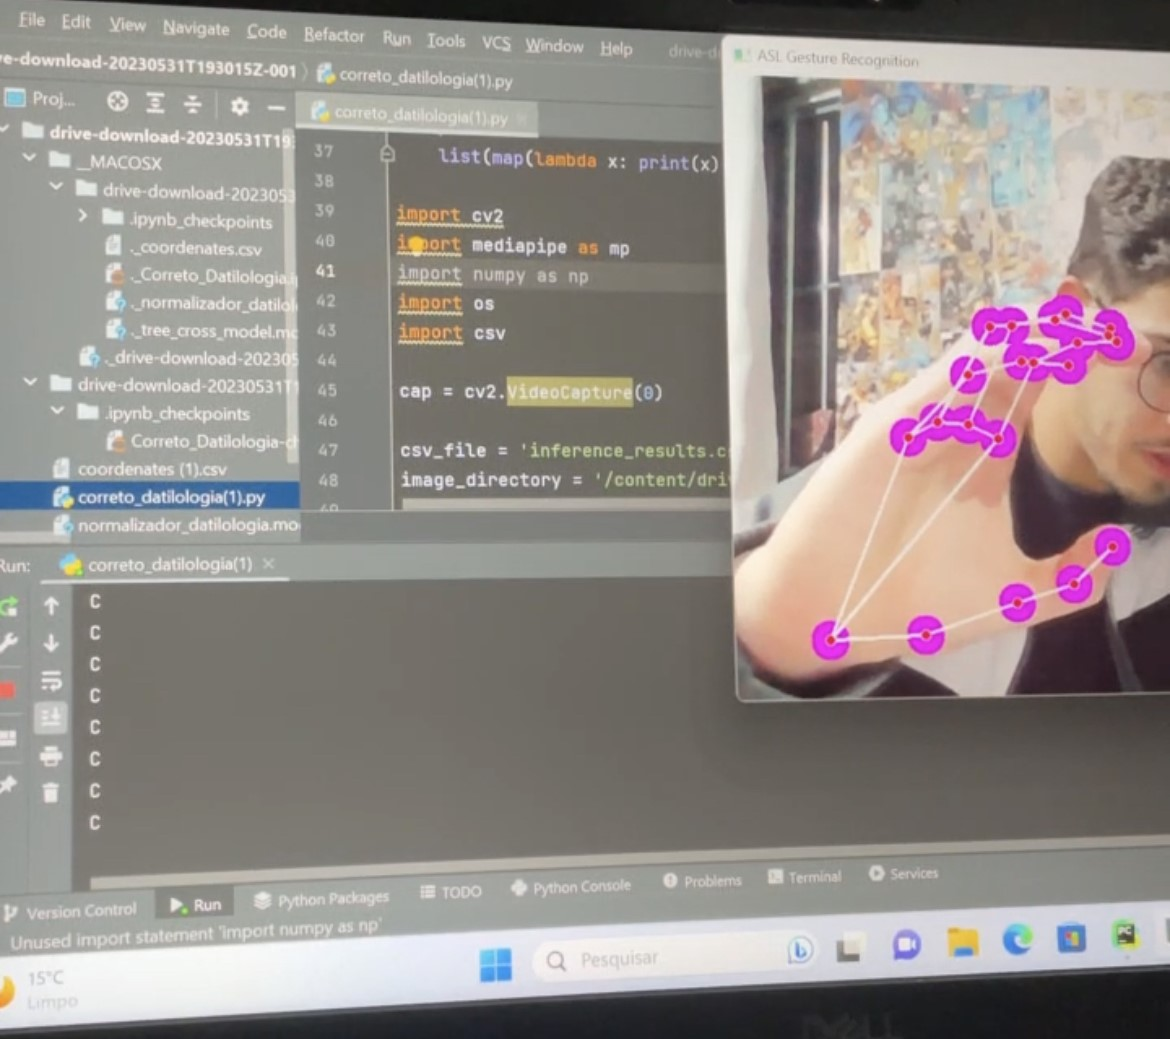

In [ ]:
import pandas as pd
from joblib import load
from sklearn.impute import SimpleImputer
import cv2
import mediapipe as mp
import numpy as np
import os
import csv

cap = cv2.VideoCapture(0)

image_directory = '/content/drive/MyDrive/'

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

i = 0
frame_count = 0
recognized_gesture = None
predicted_character = ""

coordinates_columns = [
    'IMAGE', 'VETOR1X', 'VETOR1Y', 'VETOR2X', 'VETOR2Y', 'VETOR3X',
    'VETOR3Y', 'VETOR4X', 'VETOR4Y', 'VETOR5X', 'VETOR5Y', 'VETOR6X',
    'VETOR6Y', 'VETOR7X', 'VETOR7Y', 'VETOR8X', 'VETOR8Y', 'VETOR9X',
    'VETOR9Y', 'VETOR10X', 'VETOR10Y', 'VETOR11X', 'VETOR11Y', 'VETOR12X',
    'VETOR12Y', 'VETOR13X', 'VETOR13Y', 'VETOR14X', 'VETOR14Y', 'VETOR15X',
    'VETOR15Y', 'VETOR16X', 'VETOR16Y', 'VETOR17X', 'VETOR17Y', 'VETOR18X',
    'VETOR18Y', 'VETOR19X', 'VETOR19Y', 'VETOR20X', 'VETOR20Y', 'VETOR21X',
    'VETOR21Y'
]

while True:
    ret, frame = cap.read()
    frame_count += 1
    frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frameRGB)
    landmarks = []

    if results.multi_hand_landmarks:
        for handlms in results.multi_hand_landmarks:
            filename = f"{i}.jpg"
            filepath = os.path.join(image_directory, filename)
            cv2.imwrite(filepath, frame)
            landmarks = [filename[0]]
            for id, lm in enumerate(handlms.landmark):
                h, w, c = frame.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                landmarks.extend([cx, cy])
                cv2.circle(frame, (cx, cy), 15, (0, 0, 0), 3)
            mp_drawing.draw_landmarks(
                frame,
                handlms,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )
            i += 1

    if frame_count % 5 == 0:
        if landmarks:
            rows = [{
                "IMAGE": landmarks[0],
                f"VETOR{(i+1)//2}X": landmarks[i],
                f"VETOR{(i+1)//2}Y": landmarks[i+1]
            } for i in range(1, len(landmarks), 2)]

            df = pd.DataFrame(rows, columns=coordinates_columns)

            inference_instances = df.drop(columns=['IMAGE'])

            imputer = SimpleImputer(strategy='mean')
            inference_instances_imputed = imputer.fit_transform(inference_instances)

            normalizer = load('normalizador_datilologia.model')
            tree_model = load('tree_cross_model.pkl')

            inference_instances_normalized = normalizer.transform(inference_instances_imputed)

            predictions = tree_model.predict(inference_instances_normalized)

            if len(predictions) > 0:
                recognized_gesture = predictions[0]
                predicted_character = str(recognized_gesture)
            else:
                recognized_gesture = None
                predicted_character = ""

    if recognized_gesture is not None and landmarks:
        x_min = int(min(landmarks[1::2]))
        y_min = int(min(landmarks[2::2]))
        x_max = int(max(landmarks[1::2]))
        y_max = int(max(landmarks[2::2]))
        width = x_max - x_min
        height = y_max - y_min
        cv2.putText(
            frame,
            f"Predicted: {predicted_character}",
            (x_min, y_min - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (0, 0, 0),
            2
        )
        cv2.rectangle(frame, (x_min, y_min), (x_min + width, y_min + height), (0, 0, 0), 2)

    cv2.imshow('Dactylology Gesture Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()